In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from IPython.display import Markdown, display

import pypesto
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.visualize as visualize
import pypesto.sample as sample

logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

from tqdm import tqdm

from PyPESTO.COMP.cpe_model import cpe_model, cpe_sim, MODEL_NAME, plot_data, acqf_FRP2_v4_wrapper #acqf_FRP2_v4, c
# from PyPESTO.COMP.cpe_model_grad import acqf_FRP2_v4 as acqf_FRP2_v4_grad
from PyPESTO.COMP.cpe_model import cpe_sim as cpe_sim_grad
np.random.seed(1912)



%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from PyPESTO.FRP import create_FRP2_v4

amici_model, sbml_model_filepath = create_FRP2_v4.load_amici_from_sbml()

The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first
Creating SBML model (FRP2 v4)
Creating species.
Generating parameters.
Num Termination Reactions: 10
Creating reactions
Importing AMICI model from SBML


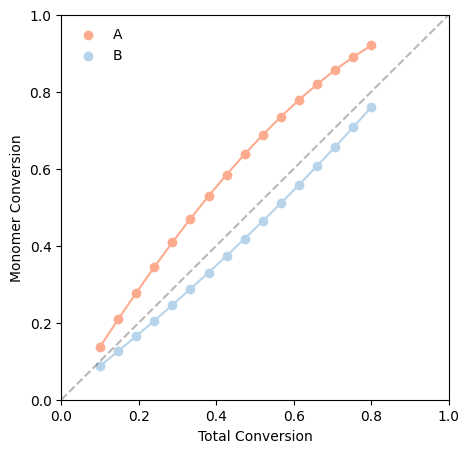

In [8]:
from matplotlib.pylab import f
from sympy import plot


rA_true = 4.0
rB_true = 0.8
rX_true = 1.0
KAA_true = 0.0
KAB_true = 0.0
KBA_true = 0.0
KBB_true = 0.0

x_eval = np.linspace(0.1, 0.8, 16)
fA0s = [0.25]
n_exp = len(fA0s)

params = [
    np.log10(rA_true),
    np.log10(rB_true),
    np.log10(rX_true),
    np.sqrt(KAA_true),
    np.sqrt(KAB_true),
    np.sqrt(KBA_true),
    np.sqrt(KBB_true)
]

sim_data = cpe_model(
    x_eval,
    params,
    exp_noise=0.00,
    fA0s=fA0s,
)

exp_data = cpe_model(
    x_eval,
    params,
    exp_noise=0.000,
    fA0s=fA0s,
)

ax = plot_data(exp_data, x_eval, n_exp=n_exp, plot_style='markers', subplot=True)
ax = plot_data(sim_data, x_eval, n_exp=n_exp, ax=ax, plot_style='lines', subplot=True)

In [9]:
objective = pypesto.Objective(
    fun=acqf_FRP2_v4_wrapper(exp_data, x_eval, fA0s=fA0s),
)

num_params = 7
lb = np.array([-2, -2, -2, 0, 0, 0, 0]).reshape(-1, 1)
ub = np.array([2, 2, 2, 1, 1, 1, 1]).reshape(-1, 1)

problem = pypesto.Problem(
    objective=objective, lb=lb, ub=ub,
    # x_fixed_indices=[2],
    # x_fixed_vals=[0],
    x_fixed_indices=[2, 3, 4, 5, 6],
    x_fixed_vals=[0, 0, 0, 0, 0]
)

optimizer_methods = [
    'Nelder-Mead',
    'Powell',
    
]

optimizer = optimize.ScipyOptimizer(method='Nelder-Mead')
# optimizer = optimize.ScipyOptimizer()
history_options = pypesto.HistoryOptions(trace_record=True)
engine = pypesto.engine.MultiProcessEngine()
n_starts = 100

# run optimization of problem 1
result = optimize.minimize(
    problem=problem, 
    optimizer=optimizer, 
    n_starts=n_starts,
    engine=engine,
    history_options=history_options,
)

Engine will use up to 8 processes (= CPU count).
100%|█████████████████████████████████████████| 100/100 [03:14<00:00,  1.95s/it]


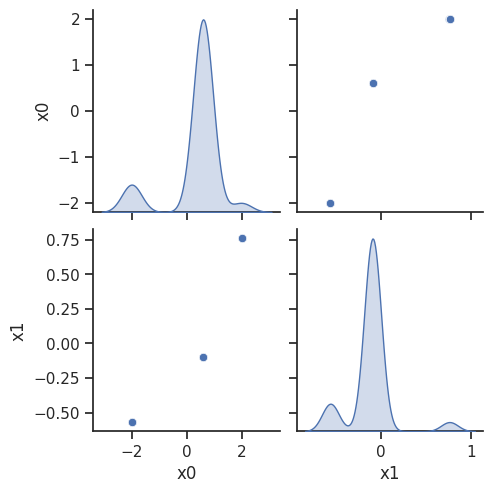

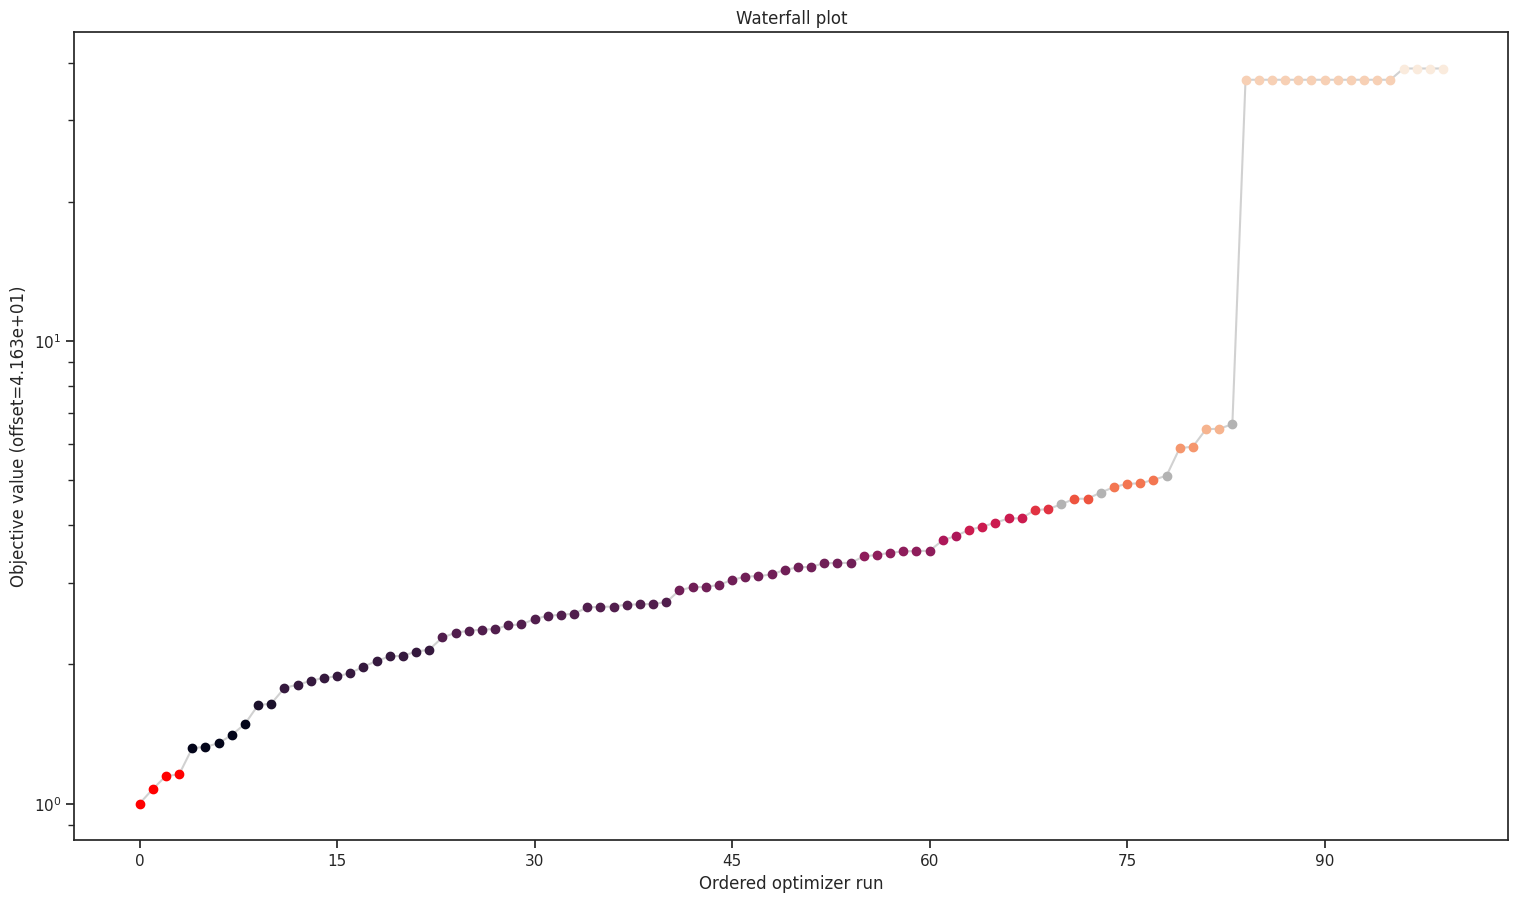

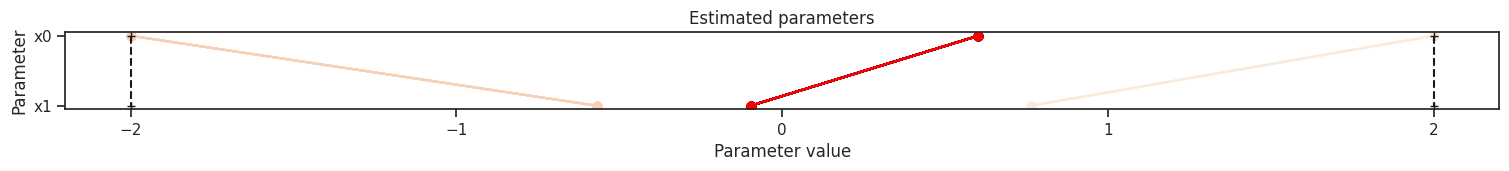

In [10]:
ax = visualize.optimization_scatter(result=result)
ax = visualize.waterfall(result)
ax = visualize.parameters(result)

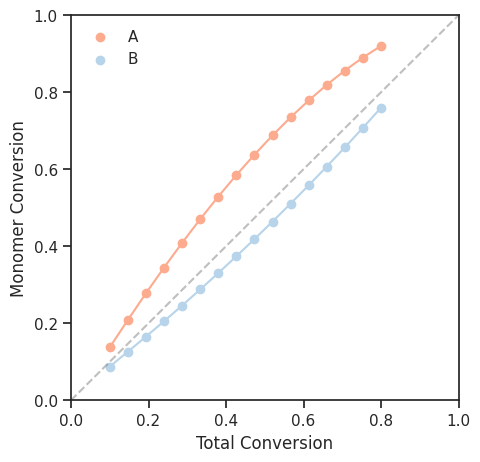

In [11]:
fit_data = cpe_model(
    x_eval,
    result.optimize_result.list[0]['x'],
    exp_noise=0.00,
    fA0s=fA0s,
)

ax = plot_data(exp_data, x_eval, n_exp=n_exp, plot_style='markers')
ax = plot_data(fit_data, x_eval, n_exp=n_exp, ax=ax, plot_style='lines')

In [13]:
print(result.optimize_result.list[0]['x'])
print(10**result.optimize_result.list[0]['x'])

[ 0.60206    -0.09691001  0.          0.          0.          0.
  0.        ]
[4.00000005 0.8        1.         1.         1.         1.
 1.        ]


In [ ]:
import pypesto.sample as sample

n_samples = 10000

sampler = sample.AdaptiveMetropolisSampler()

result = sample.sample(
    problem, n_samples=n_samples, sampler=sampler, result=result
)

In [ ]:
ax = visualize.sampling_parameter_traces(
    result, use_problem_bounds=False, size=(12, 5),
    # par_indices=[0,1,2,3]
)

In [ ]:
# Figure out how to save and reload results data